In [1]:
import os
import csv

samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# 1. Using Multiple Cameras
__Use center, left and rignt camera images.__

In [2]:
import cv2
# select a sample from the dataset samples
sample = samples[0]

imgs = []
for i in range(3):
    name = './data/IMG/'+ sample[i].split('/')[-1]
    img = cv2.imread(name)
    imgs.append(img)

True

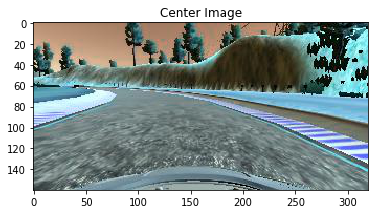

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Center Image')
plt.imshow(imgs[0], cmap='gray')
cv2.imwrite('./examples/img_center.png', imgs[0])

True

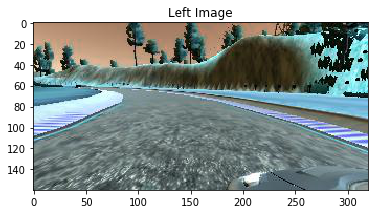

In [4]:
plt.title('Left Image')
plt.imshow(imgs[1], cmap='gray')
cv2.imwrite('./examples/img_left.png', imgs[1])

True

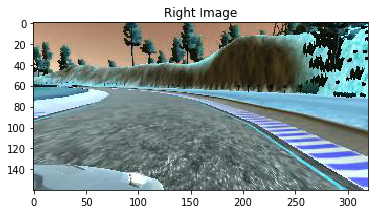

In [5]:
plt.title('Right Image')
plt.imshow(imgs[2], cmap='gray')
cv2.imwrite('./examples/img_right.png', imgs[2])

__Introduce a correction factor to train the network to steer a little harder to the right whenever I use a left camera image and a little harder to the left whenever I use a right camera image.__
- feft_steering_angle = center_steering_angle + correction
- right_steering_angle = center_steering_angle - correction

In [6]:
measurements = []
for i in range(3):
    angle = float(sample[3])
    correction = 0.2
    # left_angle = center_angle + correction
    if(i==1):
        angle += correction
    # right_angle = center_angle - correction
    elif(i==2):
        angle -= correction
    measurements.append(angle)

measurements

[0.0, 0.2, -0.2]

# 2. Data Augmentation

In [7]:
# flip a image
imgs.append(cv2.flip(imgs[0], 1))

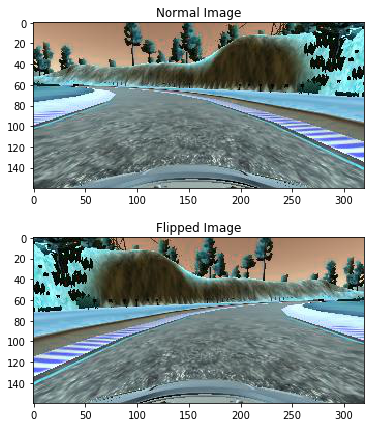

In [8]:
cv2.imwrite('./examples/img_flip.png', imgs[3])
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
axarr[0].set_title('Normal Image')
axarr[0].imshow(imgs[0], cmap="gray")
axarr[1].set_title('Flipped Image')
axarr[1].imshow(imgs[3], cmap="gray")
fig.savefig('./examples/data_augmentation.png')
fig.subplots_adjust(hspace=0.3)
plt.show()

# Generators

In [9]:
import cv2
import numpy as np
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # 1. Using Multiple Cameras #
                for i in range(3):
                    name = './data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)
                    angle = float(batch_sample[3])
                    correction = 0.2
                    # left_angle = center_angle + correction
                    if(i==1):
                        angle += correction
                    # right_angle = center_angle - correction
                    elif(i==2):
                        angle -= correction
                    images.append(image)
                    angles.append(angle)

                    # 2. DATA AUGMENTATION #
                    images.append(cv2.flip(image, 1))
                    angles.append(angle*-1.0)

            # convert data to NumPy -- the format Keras requires
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [10]:
# use the generator functiont to compile and train the model
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

# NVIDIA Architecture

In [11]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

import matplotlib.pyplot as plt

# NIVIDIA Architecture
model = Sequential()
# 3. DATA NORMALIZATION
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, 3)))
# 4. CROPPING IMAGES
model.add(Cropping2D(cropping=((70, 25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Dropout(0.7))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Dropout(0.7))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

history_object = model.fit_generator(train_generator, 
                                    samples_per_epoch=len(train_samples)*6,
                                    validation_data=validation_generator,
                                    nb_val_samples=len(validation_samples)*6,
                                    nb_epoch=5, verbose=1)

Using TensorFlow backend.


Epoch 1/5
51264/51264 [==============================] - 1575s - loss: 0.0379 - acc: 0.2284 - val_loss: 0.0575 - val_acc: 0.2272
Epoch 2/5
51264/51264 [==============================] - 1558s - loss: 0.0336 - acc: 0.2285 - val_loss: 0.0464 - val_acc: 0.2272
Epoch 3/5
51264/51264 [==============================] - 1476s - loss: 0.0326 - acc: 0.2285 - val_loss: 0.0442 - val_acc: 0.2272
Epoch 4/5
51264/51264 [==============================] - 1498s - loss: 0.0319 - acc: 0.2285 - val_loss: 0.0396 - val_acc: 0.2272
Epoch 5/5
51264/51264 [==============================] - 1475s - loss: 0.0312 - acc: 0.2285 - val_loss: 0.0374 - val_acc: 0.2272


In [12]:
print(history_object.history.keys())

dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


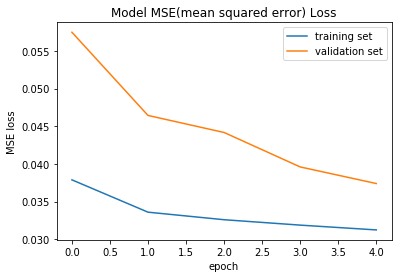

In [13]:
# summarize history for accuracy
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model MSE(mean squared error) Loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('./examples/Loss.png')
plt.show()

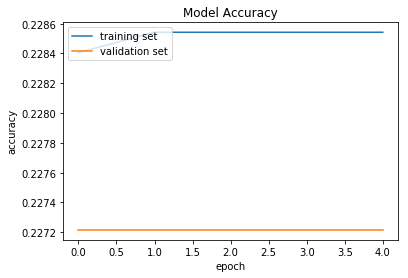

In [14]:
# summarize history for accuracy
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper left')
plt.savefig('./examples/Accuracy.png')
plt.show()

In [15]:
model.save('model.h5')
print('The model has been saved successfully.')

The model has been saved successfully.
